In [25]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set_style('darkgrid')

# Tensorflow Libraries
from tensorflow.keras import layers, Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Callback 
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Load Data

In [2]:
train_data = "./train/"
validation_data = './valid/'
test_data = './test/'

def load_data(path):
    dir = Path(path)
    hostile_data = list(dir.glob(r'hostile_images/*.jpg'))
    hostile_data = pd.Series(hostile_data, name='filepath').astype(str)
    hostile_label = pd.Series(['hostile']*len(hostile_data), name='label')
    hostile_df = pd.concat([hostile_data, hostile_label], axis=1)
    print(f'{path} hostile_data len: {len(hostile_data)}')

    non_hostile_data = list(dir.glob(r'non_hostile_images/*.jpg'))
    non_hostile_data = pd.Series(non_hostile_data, name='filepath').astype(str)
    non_hostile_label = pd.Series(['non_hostile']*len(non_hostile_data), name='label')
    non_hostile_df = pd.concat([non_hostile_data, non_hostile_label], axis=1)
    print(f'{path} non_hostile_data len: {len(non_hostile_data)}')

    combined_df = pd.concat([hostile_df, non_hostile_df], ignore_index=True)
    return combined_df

train_df = load_data(train_data)
valid_df = load_data(validation_data)
test_df = load_data(test_data)
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)
train_df.head()

./train/ hostile_data len: 400
./train/ non_hostile_data len: 4501
./valid/ hostile_data len: 100
./valid/ non_hostile_data len: 1126
./test/ hostile_data len: 56
./test/ non_hostile_data len: 626
(4901, 2)
(1226, 2)
(682, 2)


,filepath,label
0,train\hostile_images\0.jpg,hostile
1,train\hostile_images\10.jpg,hostile
2,train\hostile_images\100.jpg,hostile
3,train\hostile_images\101.jpg,hostile
4,train\hostile_images\102.jpg,hostile


## Oversample Minority Class

In [3]:
minority_train = train_df[train_df['label']=='hostile']
minority_valid = valid_df[valid_df['label']=='hostile']

aug_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2] # brightness 
)

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Split the data into three categories.
aug_train_images = aug_image_generator.flow_from_dataframe(
    dataframe=minority_train,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    save_to_dir='aug_train', # save path for augmented images
    save_prefix='aug-',
    save_format='jpg',
    seed=111
)

aug_val_images = aug_image_generator.flow_from_dataframe(
    dataframe=minority_valid,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    save_to_dir='aug_valid', # save path for augmented images
    save_prefix='aug-',
    save_format='jpg',
    seed=111
)

Found 400 validated image filenames belonging to 1 classes.
Found 100 validated image filenames belonging to 1 classes.


In [27]:
# Uncomment to generate images
# i = 0
# while i<150:
#     image=next(aug_train_images)
#     i+=1

# i = 0
# while i<50:
#     image=next(aug_val_images)
#     i+=1

In [5]:
def load_aug_data(path, aug_path):
    dir = Path(path)
    aug_dir = Path(aug_path)

    hostile_data = list(aug_dir.glob(r'*.jpg'))
    non_hostile_data = list(dir.glob(r'non_hostile_images/*.jpg'))
    n = min(len(hostile_data), len(non_hostile_data))

    hostile_data = pd.Series(hostile_data, name='filepath').astype(str)
    hostile_data = hostile_data.sample(n=n, random_state=111).reset_index()
    hostile_label = pd.Series(['hostile']*n, name='label')
    hostile_df = pd.concat([hostile_data, hostile_label], axis=1)

    non_hostile_data = pd.Series(non_hostile_data, name='filepath').astype(str)
    non_hostile_data = non_hostile_data.sample(n=n, random_state=111).reset_index()
    non_hostile_label = pd.Series(['non_hostile']*n, name='label')
    non_hostile_df = pd.concat([non_hostile_data, non_hostile_label], axis=1)

    combined_df = pd.concat([hostile_df, non_hostile_df], ignore_index=True)
    combined_df[['filepath','label']] = combined_df[['filepath','label']].astype(str)
    return combined_df

train_df = load_aug_data(train_data, 'aug_train')
valid_df = load_aug_data(validation_data, 'aug_valid')
print(train_df.shape)
print(valid_df.shape)

(9002, 3)
(2252, 3)


## Data Preprocessing

In [6]:
image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Split the data into three categories.
train_images = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=111
)

val_images = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=111
)

test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 9002 validated image filenames belonging to 2 classes.
Found 2252 validated image filenames belonging to 2 classes.
Found 682 validated image filenames belonging to 2 classes.


In [7]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

## Model Training

In [8]:
# Load the pretained model
pretrained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [9]:
# Create checkpoint callback
checkpoint_path = "classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [10]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

In [34]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)

Epoch 1/100
282/282 [==============================] - 527s 2s/step - loss: 0.3687 - accuracy: 0.8543 - val_loss: 0.0610 - val_accuracy: 0.9805
Epoch 2/100
282/282 [==============================] - 482s 2s/step - loss: 0.0944 - accuracy: 0.9646 - val_loss: 0.0310 - val_accuracy: 0.9885
Epoch 3/100
282/282 [==============================] - 492s 2s/step - loss: 0.0559 - accuracy: 0.9801 - val_loss: 0.0236 - val_accuracy: 0.9916
Epoch 4/100
282/282 [==============================] - 446s 2s/step - loss: 0.0393 - accuracy: 0.9858 - val_loss: 0.0282 - val_accuracy: 0.9902
Epoch 5/100
282/282 [==============================] - 457s 2s/step - loss: 0.0328 - accuracy: 0.9889 - val_loss: 0.0147 - val_accuracy: 0.9956
Epoch 6/100
282/282 [==============================] - 447s 2s/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0142 - val_accuracy: 0.9942
Epoch 7/100
282/282 [==============================] - 501s 2s/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0150 - val_accuracy:

In [11]:
# save the model to disk
# model.save('model_inceptionv3_oversample.h5')

# load the model from disk
loaded_model = tf.keras.models.load_model('model_inceptionv3_oversample.h5')

## Model Evaluation

In [13]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
results = loaded_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00282
Test Accuracy: 99.71%


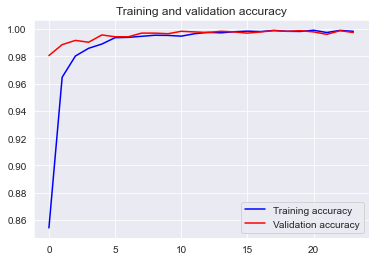

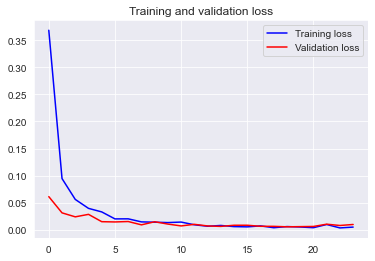

In [39]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## Predictions

In [17]:
# Predict the label of the test_images
pred = loaded_model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

22/22 [==============================] - 21s 949ms/step
The first 5 predictions: ['hostile', 'hostile', 'hostile', 'hostile', 'hostile']


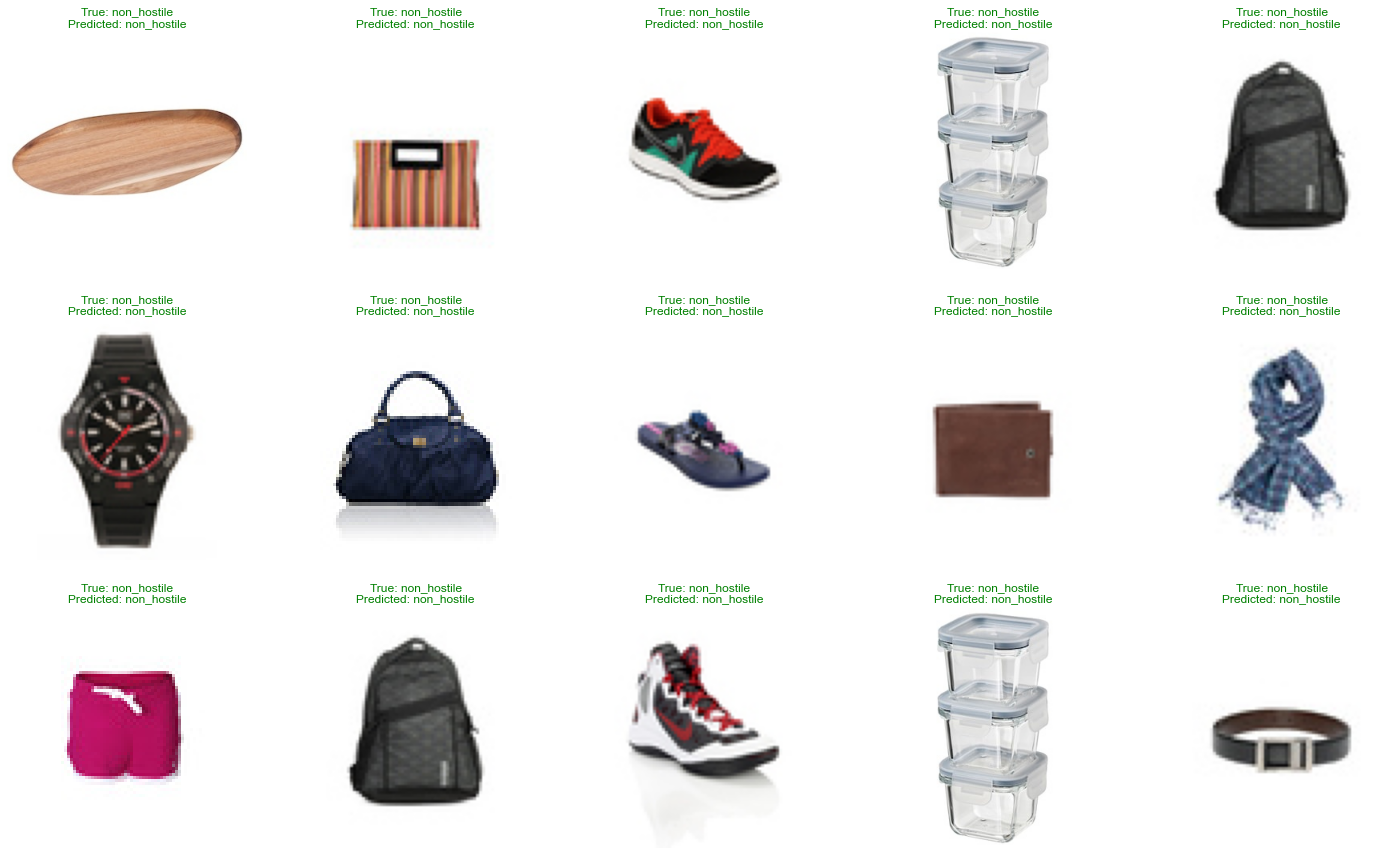

<Figure size 432x288 with 0 Axes>

In [26]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## Results

In [20]:
y_test = list(test_df.label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
hostile,0.982143,0.982143,0.982143,56.000000
non_hostile,0.998403,0.998403,0.998403,626.000000
accuracy,0.997067,0.997067,0.997067,0.997067
macro avg,0.990273,0.990273,0.990273,682.000000
weighted avg,0.997067,0.997067,0.997067,682.000000


## Extra Tests
On unseen data

In [21]:
unseen_test_data = './unseen_test/'
unseen_test_df = load_data(unseen_test_data)
print(unseen_test_df.shape)

./unseen_test/ hostile_data len: 12
./unseen_test/ non_hostile_data len: 8
(20, 2)


In [22]:
unseen_test_images = image_generator.flow_from_dataframe(
    dataframe=unseen_test_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 20 validated image filenames belonging to 2 classes.


In [23]:
# Predict the label of the test_images
pred1 = loaded_model.predict(unseen_test_images)
pred1 = np.argmax(pred1,axis=1)

# Map the label
labels1 = (train_images.class_indices)
labels1 = dict((v,k) for k,v in labels1.items())
pred1 = [labels1[k] for k in pred1]

1/1 [==============================] - 1s 553ms/step


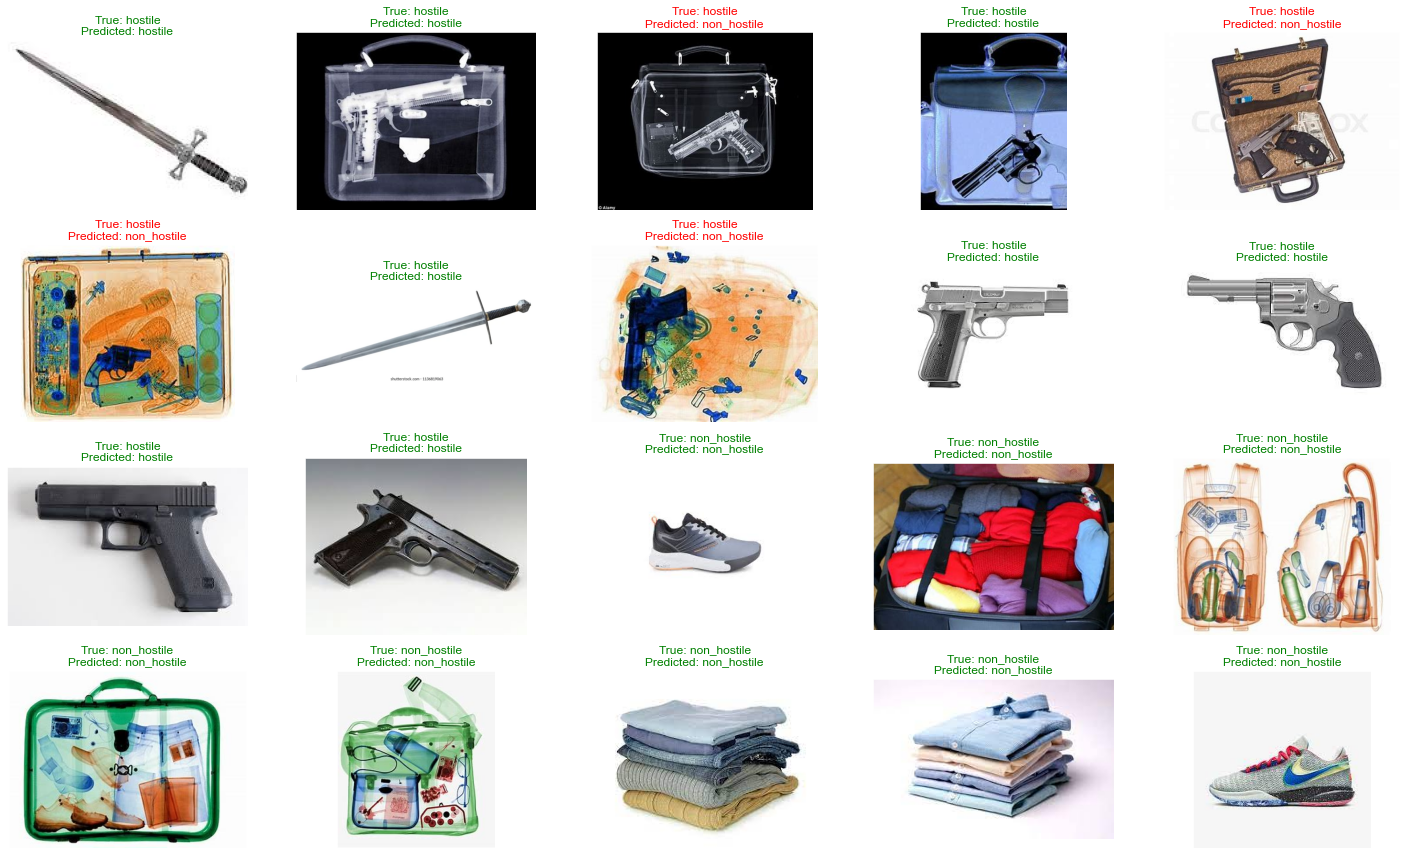

<Figure size 432x288 with 0 Axes>

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unseen_test_df.filepath.iloc[i]))
    if unseen_test_df.label.iloc[i] == pred1[i]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {unseen_test_df.label.iloc[i]}\nPredicted: {pred1[i]}", color=color)
plt.show()
plt.tight_layout()